# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) Not needed atm.
    preprocess_transforms = transforms.Compose([transforms.Resize((image_size, image_size)),
                                     transforms.ToTensor()]) #,
                                     #normalize])
    
    
    dataset = datasets.ImageFolder(data_dir, preprocess_transforms)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
# Resubmission Note: Tried smaller batch sizes between 20-32 but they resulted in very noisy training/losses
#                    Was expecting more stability. 
#                    Stuck with 128, the batch size referenced in original DCGAN paper as it was less noisy and better results for my network. (https://arxiv.org/pdf/1511.06434.pdf)
batch_size = 128  # Note: Code below implies a batch_size >= 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


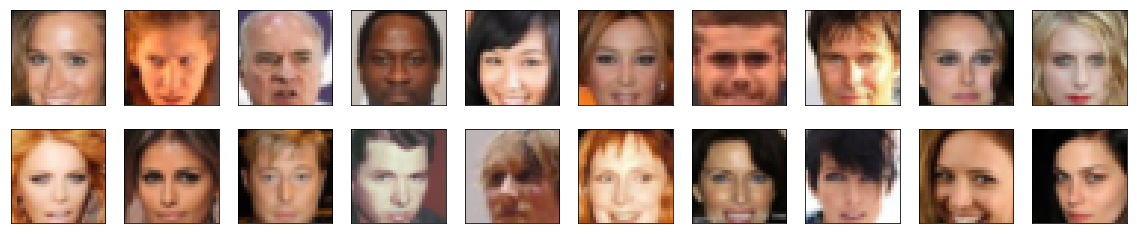

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(np.arange(20))
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range   # Grab min/max values from provided range
    x = x * (max - min) + min  # General formula to scale by range
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8902)
Max:  tensor(0.8980)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.kernel_size = 4
        self.conv_dim = conv_dim
        
        # complete init function
        
        # First-Conv Layer | Input: 32x32x3 | Output: 16x16x64
        self.conv1 = nn.Conv2d(3, conv_dim, self.kernel_size, stride=2, padding=1, bias=False)
        
        # Second-Conv Layer + Batch Normalization 
        # Input: 16x16x64 | Output: 8x8x128
        self.conv2 = nn.Sequential(*[
            nn.Conv2d(conv_dim, conv_dim*2, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2)
        ])
        
        # Third-Conv Layer + Batch Normalization
        # Input: 8x8x128 | Output: 4x4x256
        self.conv3 = nn.Sequential(*[
            nn.Conv2d(conv_dim*2, conv_dim*4, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4)
        ])
        
        # Final Output Layer
        # Input: 4x4x256 | Output: Logit (0-1)
        self.output_layer = nn.Linear(conv_dim*4*4*4, 1)

        # Dropout Layer to improve training | Feedback tip
        # Resubmission Note: Helps focus the generator on data distribution rather than learning exploits to fool 
        #                    the discriminator (https://github.com/tensorflow/magenta/blob/master/magenta/reviews/GAN.md#disadvantages)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out))
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out))
        
        # Dropout layer | Feedback Tip
        # Resubmission Note: Helps focus the generator on data distribution rather 
        #                    than learning exploits to fool the discriminator (https://github.com/tensorflow/magenta/blob/master/magenta/reviews/GAN.md#disadvantages)
        out = self.dropout(out)
        
        # Last Layer Output
        # Note: Will be using BCELogitsLoss later so no sigmoid applied to the output yet here
        flattened_output = out.view(-1, self.conv_dim*4*4*4)        
        out = self.output_layer(flattened_output)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        self.kernel_size = 4
        
        # complete init function
        self.input_fc_layer = nn.Linear(z_size, conv_dim*4*4*2) # Matching the expected dimensions of First t-conv layer
        
        # Upsampling Transpose Convolutional Layers
        
        # First-Tconv Layer + Batch Normalization
        # Input: 2x2x512 | Output: 4x4x256
        self.tconv1 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4)
        ])
        
        # Second-Tconv Layer + Batch Normalization
        # Input: 4x4x256 | Output: 8x8x128
        self.tconv2 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2)
        ])
        
        # Third-Tconv Layer + Batch Normalization
        # Input: 8x8x256 | Output: 16x16x128
        # Resubmission Note: Added 1 extra tconv layer to the generator to make it deeper/expressive than the discriminator. Improved Output.
        #                    See Note 1 Here: https://github.com/tensorflow/magenta/blob/master/magenta/reviews/GAN.md#disadvantages
        self.tconv3 = nn.Sequential(*[
            nn.ConvTranspose2d(conv_dim*2, conv_dim, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim)
        ])
        
        # Final-Tconv Layer | No Batch Normalization
        # Input: 16x16x128 | Output: 32x32x3
        self.output_tconv = nn.ConvTranspose2d(conv_dim, 3, self.kernel_size, stride=2, padding=1, bias=False)

        # Resubmission Note: Dropout on the generator was resulting in more distortions in the resulting images.
        #       Decided to not use it. Intention was to improve train/generalize
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        
        # Convert Latent Vector + First Fully-Connected layer to correct dimensions
        out = self.input_fc_layer(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # Dimensions: 2x2x256

        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        
        # Last Output Tconv + TANH (-1 to 1 pixel values)
        out = F.tanh(self.output_tconv(out))
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        print('Updating Weight | ' + str(classname))
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [25]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Updating Weight | Conv2d
Updating Weight | Conv2d
Updating Weight | Conv2d
Updating Weight | Linear
Updating Weight | Linear
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d
Updating Weight | ConvTranspose2d
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=4096, out_features=1, bias=True)
  (dropout): Dropout(p=0.1)
)

Generator(
  (input_fc_layer): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): Sequential(
    (0): ConvTr

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [27]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    # Get Batch Size
    batch_size = D_out.size(0)
    
    # Create Real Labels | Enabled label smoothing after first submission to pursue better results
    # Resubmission Note: Reduced label smoothing from 0.9 to 0.99 to improve discriminator's adversarial feedback.
    #       Was seeing that the discriminator was too weak with Dropout and Label smoothing at 0.9.
    labels = torch.ones(batch_size) #* 0.99 
    
    if train_on_gpu:
        labels = labels.cuda()
        
    # Binary Cross Entropy w/ Logits
    criterion = nn.BCEWithLogitsLoss()

    #print("D_out: " + str(D_out.squeeze()) + " \n Labels: " + str(labels))
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    # Get Batch Size
    batch_size = D_out.size(0)
    
    # Create Fake Labels
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [28]:
import torch.optim as optim

# Utilizing Parameters from DCGAN Paper (https://arxiv.org/pdf/1511.06434.pdf)
# Resubmission Note: Tried numerous variations on a lower learning rate 0.0001-0.0002 and lower beta1 of 0.1-0.3 but
#                    was seeing unstable training and the results were more distorted after even extra training loops for my network.
#                    However, I did find that utilizing the original DCGAN training parameters for the first 10 epochs and then reducing
#                    the learning rate to 0.0001 and beta1 to 0.1 did actually help stabilize trianing improvements and produced better results.
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [29]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    optim_updated = False
    
    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # ---------------------------------------------------
            
            # Zero Out previous gradient calculations
            d_optimizer.zero_grad()
            
            # Real Images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            #print("D_real_loss: " + str(d_real_loss.item()))
            
            # Fake Images | Creating latent vectors similarly to fixed_z above
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            # Generate Fake Images from the Latent Vectors
            fake_images = G(z)
            
            # Discriminator Loss on Fake Images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            #print('D_fake_loss: ' + str(d_fake_loss.item()))
            
            # Total Discriminator Loss
            d_loss = d_real_loss + d_fake_loss
            
            # Discriminator Backprop
            d_loss.backward()
            d_optimizer.step()

            
            
            # 2. Train the generator with an adversarial loss
            # -----------------------------------------------
            
            # Zero out previous gradient calculations
            g_optimizer.zero_grad()
            
            # Generate Latent Vectors
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            # Generate Fake Images
            fake_images = G(z)
            
            # Compute Adversarial Loss from discriminator with flipped labels
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # Generator Backprop
            g_loss.backward()
            g_optimizer.step()
            
            # Set lower learning rate / beta1 value for fine-tuning network after 10 epochs
            # Resubmission Note: Found that after 10 epochs, reducing the learning rate + beta1 helped stabilize training and achieve better results.
            if (epoch + 1) == 10 and (not optim_updated):
                for param_group in g_optimizer.param_groups:
                    param_group['lr'] = 0.0001
                    param_group['betas'] = (0.1,beta2)
                for param_group in d_optimizer.param_groups:
                    param_group['lr'] = 0.0001
                    param_group['betas'] = (0.1,beta2)
                optim_updated = True
                print('Updated optimizers | lr = 0.0001 | Beta1 = 0.1')
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [30]:
# set number of epochs
n_epochs = 15


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   15] | d_loss: 1.4547 | g_loss: 1.0814
Epoch [    1/   15] | d_loss: 0.4044 | g_loss: 4.0388
Epoch [    1/   15] | d_loss: 0.2633 | g_loss: 2.9754
Epoch [    1/   15] | d_loss: 1.1542 | g_loss: 6.1798
Epoch [    1/   15] | d_loss: 0.6388 | g_loss: 2.8309
Epoch [    1/   15] | d_loss: 0.7566 | g_loss: 2.1011
Epoch [    1/   15] | d_loss: 0.8672 | g_loss: 3.0975
Epoch [    1/   15] | d_loss: 0.7425 | g_loss: 2.7457
Epoch [    1/   15] | d_loss: 0.8048 | g_loss: 2.2338
Epoch [    1/   15] | d_loss: 0.7225 | g_loss: 3.2630
Epoch [    1/   15] | d_loss: 0.7318 | g_loss: 2.9289
Epoch [    1/   15] | d_loss: 0.5456 | g_loss: 3.7242
Epoch [    1/   15] | d_loss: 0.7934 | g_loss: 2.2182
Epoch [    1/   15] | d_loss: 0.8982 | g_loss: 2.1942
Epoch [    1/   15] | d_loss: 0.8055 | g_loss: 2.6655
Epoch [    2/   15] | d_loss: 0.6068 | g_loss: 2.5410
Epoch [    2/   15] | d_loss: 0.7373 | g_loss: 3.3847
Epoch [    2/   15] | d_loss: 0.8430 | g_loss: 2.5453
Epoch [    2/   15] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

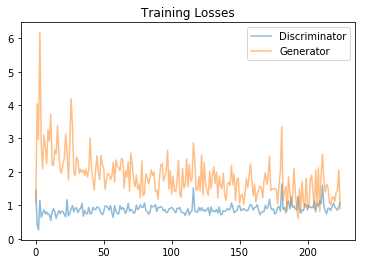

In [31]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [32]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [33]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

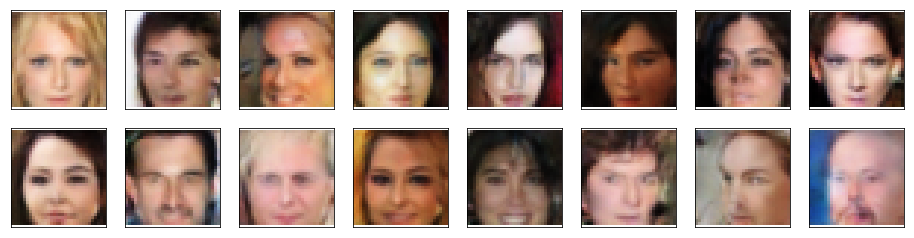

In [34]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)<br>

The model generates reasonably realistic images of diverse faces. All the images are blurry but is characteristic of DCGAN output that is not focused on high-resolution outputs. There is still some distortion seen on some images: some ears are missing, eyebrows are not always present, and hair seems limited to just blondish-white and black. The model did however pick up on makeup, hairstyles, and smiling and non-smiling faces.

Dataset Improvements:<br>
- Injecting more diversity into the celebrity dataset could help the model generalize better and in turn generate more diverse output images.
- Ensuring that all pixels are normalized across the dataset

Model Improvements:<br>
- The discriminator is currently using the default negative_slope for its leaky_relus. Adjusting this negative slope could optimize the discriminator to better detect real and or fake images. In turn this would provide better adversarial loss to the generator to learn from to generate more realistic output images. After many tests, it was determined that a higher negative slope was not showing better results for my network.
- Adding more layers to the Discriminator and Generator. The discriminator could learn from more complicated features in the datasets. The generator could generate more complicated features in its output.
- Making the generator deeper than the discriminator has been reported to produce better results. Testing this could help.

Optimizers and Hyperparameters:
- The real and fake losses were calculated using the Binary Cross Entropy Loss with Logits criterion. While this provides good results and is suited well for this problem, it is possible that a Mean Squared Loss criterion could provide better results and can be tested.
- Number of Epochs: The generator "discovers" some important ways to modify the latent vectors into realistic faces within the first 50 batches of data. Most noteably there is a spike in discriminator loss around batch 40 which indicates that the generator learned a new aspect of these faces. However, after 100 batches it struggles to improve further as the discriminator gets better at detecting fake images. Around batch 200 the generators loss begins to increase but it does continue to learn key features - it just can't fool the discriminator as well. This indicates that for this model and dataset around 150 batches of size 128 (~10 epochs) is sufficient to train the model to generate reasonably realistic faces.

Resubmission Notes:
Reworked the network with tips provided by my first review of the project. First submission results were decent but could be tuned even further. With the new submission I have gone through numerous trials of improving the network which resulted in a lot of learnings and improved results. The batch size and learning rate was kept the same, but the learning rate is dropped to 0.0001 after 10 epochs after finding this to fine-tune the training. The discriminator was improved with dropout and by reducing the label smoothing affect in the real_loss function. Additionally, the generator was improved with 1 more tconv layer which allowed it to learn and tune more features for the output images.
- <b>Batch Size:</b> Tried smaller batch sizes between 20-32 as suggested but they resulted in very noisy training/losses even with reduced learning rate and beta. Was expecting more stability. Ended up sticking with a batch size of 128 - the batch size referenced in original DCGAN paper as it was less noisy and better results for my network. (https://arxiv.org/pdf/1511.06434.pdf)
- <b>Learning Rate:</b> Found that after 10 epochs, reducing the learning rate + beta1 helped stabilize training and achieve better results. I tried numerous variations of a lower learning rate 0.0001-0.0002 and lower beta1 of 0.1-0.3 but was seeing unstable training and the results were more distorted after even more training epochs on my network. However, I did find that utilizing the original DCGAN training parameters for the first 10 epochs and then reducing the learning rate to 0.0001 and beta1 to 0.1 did actually help stabilize trianing improvements and produced better results.
- <b>Discriminator Improvement:</b> Added dropout between discriminator layers. Helps focus the generator on data distribution rather than learning exploits to fool the discriminator (https://github.com/tensorflow/magenta/blob/master/magenta/reviews/GAN.md#disadvantages)
- <b>Generator Improvements:</b> Added 1 extra tconv layer to the generator to make it deeper/expressive than the discriminator. Improved Output. See Note 1 in GAN.md#disadvantages link above. However, adding dropout on the generator was resulting in more distortions in the resulting images so I decided not use it. Intention was to improve train/generalize.
        
            

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.